# Membuat Model Machine Learning dengan Data Time Series

### **Siswa:** Hanzalah Assidiq

**Dataset:** kaggle datasets download -d vijayvvenkitesh/microsoft-stock-time-series-analysis

## Import Libraries

In [93]:
import pandas as pd
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
from keras.layers import Dense, LSTM
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import StandardScaler
df = pd.read_csv('Microsoft_Stock.csv')
df

,Date,Open,High,Low,Close,Volume
0,4/1/2015 16:00:00,40.60,40.76,40.31,40.72,36865322
1,4/2/2015 16:00:00,40.66,40.74,40.12,40.29,37487476
2,4/6/2015 16:00:00,40.34,41.78,40.18,41.55,39223692
3,4/7/2015 16:00:00,41.61,41.91,41.31,41.53,28809375
4,4/8/2015 16:00:00,41.48,41.69,41.04,41.42,24753438
...,...,...,...,...,...,...
1506,3/25/2021 16:00:00,235.30,236.94,231.57,232.34,34061853
1507,3/26/2021 16:00:00,231.55,236.71,231.55,236.48,25479853
1508,3/29/2021 16:00:00,236.59,236.80,231.88,235.24,25227455
1509,3/30/2021 16:00:00,233.53,233.85,231.10,231.85,24792012


In [94]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1511 entries, 0 to 1510
Data columns (total 6 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   Date    1511 non-null   object 
 1   Open    1511 non-null   float64
 2   High    1511 non-null   float64
 3   Low     1511 non-null   float64
 4   Close   1511 non-null   float64
 5   Volume  1511 non-null   int64  
dtypes: float64(4), int64(1), object(1)
memory usage: 71.0+ KB


In [95]:
df.isnull().sum()

Date      0
Open      0
High      0
Low       0
Close     0
Volume    0
dtype: int64

In [96]:
df = df[['Date', 'Volume']]
df.head()

,Date,Volume
0,4/1/2015 16:00:00,36865322
1,4/2/2015 16:00:00,37487476
2,4/6/2015 16:00:00,39223692
3,4/7/2015 16:00:00,28809375
4,4/8/2015 16:00:00,24753438


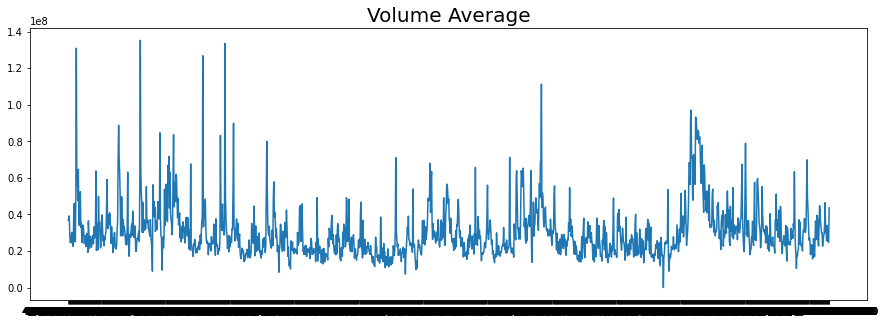

In [99]:
dates = df['Date'].values
vol = df['Volume'].values
#humd = df['HumidityAvgPercent'].values

plt.figure(figsize = (15,5))
plt.plot(dates, vol)
plt.title('Volume Average',
           fontsize=20);

## Normalization

In [100]:
min_max_scaler = MinMaxScaler(feature_range=(0,1))
scaled = min_max_scaler.fit_transform(df[['Volume']])
df[['Volume']] = scaled

/usr/local/lib/python3.8/dist-packages/pandas/core/frame.py:3678: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[col] = igetitem(value, i)


In [101]:
vol = np.array(df['Volume'].values, dtype=np.float)
dates = df['Date'].values
dates_train, dates_test, vol_train, vol_test = train_test_split(dates, vol, test_size=0.2, shuffle=False)

<ipython-input-101-08f321e9c82f>:1: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  vol = np.array(df['Volume'].values, dtype=np.float)


In [102]:
vol

array([0.27207096, 0.27667523, 0.28952415, ..., 0.18594457, 0.18272206,
       0.32208485])

In [103]:
print(len(vol_train), len(vol_test))

1208 303


## Modeling

In [104]:
def windowed_dataset(series, window_size, batch_size, shuffle_buffer):
    series = tf.expand_dims(series, axis=-1)
    ds = tf.data.Dataset.from_tensor_slices(series)
    ds = ds.window(window_size + 1, shift=1, drop_remainder=True)
    ds = ds.flat_map(lambda w: w.batch(window_size + 1))
    ds = ds.shuffle(shuffle_buffer)
    ds = ds.map(lambda w: (w[:-1], w[-1:]))
    return ds.batch(batch_size).prefetch(1)

In [105]:
train_set = windowed_dataset(vol_train, window_size=60, batch_size=100, shuffle_buffer=1000)
model = tf.keras.models.Sequential([
  tf.keras.layers.Bidirectional(LSTM(60, return_sequences=True, input_shape=[None, 1])),
  tf.keras.layers.Bidirectional(LSTM(60)),
  tf.keras.layers.Dense(30, activation="relu"),
  tf.keras.layers.Dropout(0.2),
  tf.keras.layers.Dense(10, activation="relu"),
  tf.keras.layers.Dropout(0.5),
  tf.keras.layers.Dense(1),
])

In [106]:
skala_data = (vol.max() - vol.min()) * 10/100
print(skala_data)

0.1


In [107]:
class myCallback(tf.keras.callbacks.Callback):
  def on_epoch_end(self, epoch, logs={}):
    if(logs.get('mae')<0.1):
      print("\nSelamat nilai MAE model anda < 10% !!")
      self.model.stop_training = True
callbacks = myCallback()

In [108]:
optimizer = tf.keras.optimizers.SGD(learning_rate=1.0000e-04, momentum=0.9)
model.compile(loss=tf.keras.losses.Huber(),
              optimizer=optimizer,
              metrics=["mae"])
history = model.fit(train_set,epochs=100, callbacks=[callbacks])

Epoch 1/100
12/12 [==============================] - 6s 24ms/step - loss: 0.0263 - mae: 0.2077
Epoch 2/100
12/12 [==============================] - 0s 19ms/step - loss: 0.0255 - mae: 0.2041
Epoch 3/100
12/12 [==============================] - 0s 17ms/step - loss: 0.0249 - mae: 0.2010
Epoch 4/100
12/12 [==============================] - 0s 18ms/step - loss: 0.0241 - mae: 0.1969
Epoch 5/100
12/12 [==============================] - 0s 19ms/step - loss: 0.0233 - mae: 0.1935
Epoch 6/100
12/12 [==============================] - 0s 17ms/step - loss: 0.0227 - mae: 0.1897
Epoch 7/100
12/12 [==============================] - 0s 20ms/step - loss: 0.0218 - mae: 0.1852
Epoch 8/100
12/12 [==============================] - 0s 19ms/step - loss: 0.0212 - mae: 0.1819
Epoch 9/100
12/12 [==============================] - 0s 19ms/step - loss: 0.0205 - mae: 0.1786
Epoch 10/100
12/12 [==============================] - 0s 20ms/step - loss: 0.0200 - mae: 0.1748
Epoch 11/100
12/12 [=============================